In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from textblob import TextBlob
from textblob import Word
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn import ensemble

%matplotlib inline

C:\Users\lkonig\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Wine Spectator magazine, one of the largest wine scoring operations indicates the following qualitative rating by score:

60-69. Wines are flawed and not recommended

70-79 Wines are flawed and taste average

80-84 wines are above average to good

85-90 wines are good to very good

90-94 wines are superior to exceptional

95-100. Wines are benchmark examples or classic

In [2]:
df = pd.read_csv('winemag-data_first150k.csv')

In [3]:
#Insert column to flag "Exceptional wines"
df['is_exceptional'] = np.where(df['points']>=90, 1, 0)

#set null prices
df.loc[pd.isnull(df.price),'price']=df.price.mean()

Text(0.5,1,'Wines counts by Top 20 countries')

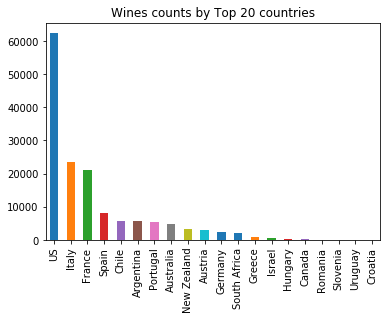

In [4]:
# bar plot
df['country'].value_counts().head(20).plot.bar()
plt.title('Wines counts by Top 20 countries')

Text(0.5,1,'Wine counts by Points Assigned')

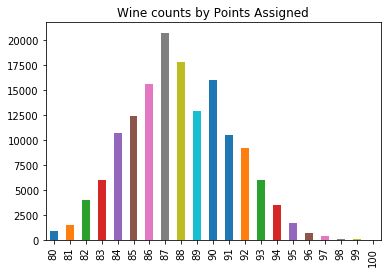

In [5]:
df['points'].value_counts().sort_index().plot.bar()
plt.title('Wine counts by Points Assigned')

([<matplotlib.axis.XTick at 0x254ce8f5a58>,
 <a list of 2 Text xticklabel objects>)

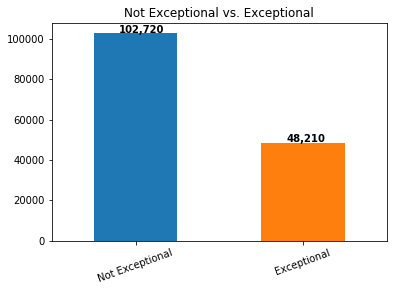

In [6]:
ax = df['is_exceptional'].value_counts().sort_index().plot.bar()
y =  df.groupby(['is_exceptional']).size()
y = [str(x) for x in y.tolist()]

for i, v in enumerate(y):
    ax.text(i-.1, int(v)+500, '{:,}'.format(int(v)), color='black', fontweight='bold')
    
xaxis_labels = ['Not Exceptional','Exceptional']
    
plt.title('Not Exceptional vs. Exceptional')
plt.xticks(np.arange(2),xaxis_labels , rotation=20)
  

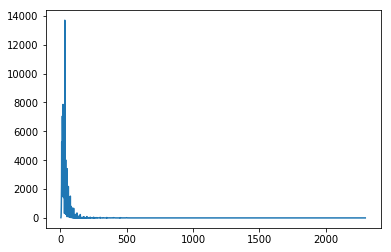

In [7]:
#Plot Price
df['price'].value_counts().sort_index().plot.line()

Text(0.5,1,'Wine Price vs. Points')

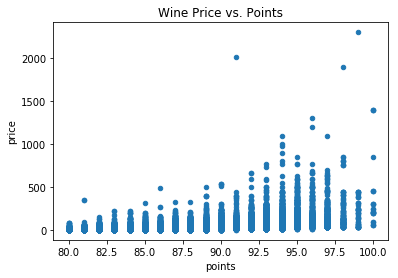

In [8]:
#Scatter Plot
df.plot.scatter(x='points', y='price')
plt.title('Wine Price vs. Points')

In [9]:
#avg word function
def avg_word(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/len(words))


In [10]:
# #Add feaures


# #set null prices
# df.loc[pd.isnull(df.price),'price']=df.price.mean()

# #text features
# stop = stopwords.words('english')

# df['word_count'] = df['description'].apply(lambda x: len(str(x).split(" ")))
# df['char_count'] = df['description'].str.len() ## this also includes spaces
# df['avg_word'] = df['description'].apply(lambda x: avg_word(x))
# df['stopwords'] = df['description'].apply(lambda x: len([x for x in x.split() if x in stop]))
# df['numerics'] = df['description'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
# df['percent'] = df['description'].apply(lambda x: len([x for x in x.split() if x.endswith('%')]))

# #Preprocessing
# df['description'] = df['description'].apply(lambda x: " ".join(x.lower() for x in x.split()))
# df['description'] = df['description'].str.replace('[^\w\s]','')
# df['description'] = df['description'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

# #combine description and designation into 1 column
# df['description'] = df['designation'].astype(str) + ' ' + df['winery'] + ' ' + df['description']

# #get rid of description so you can get dummies
# df_description = df[['description']]
# df.drop(['Unnamed: 0','description','designation','winery'], axis=1, inplace=True)
# df = pd.get_dummies(df)
# df.head()

In [11]:
# #Create tfidf features
# tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word',
# stop_words= 'english',ngram_range=(1,1))
# train_vect = tfidf.fit_transform(df_description['description'])


# columns = tfidf.get_feature_names()
# print(train_vect.shape)
# print(train_vect.toarray())
# a = train_vect.toarray()

# df2 = pd.DataFrame(np.reshape(a, (len(a),train_vect.shape[1])),columns=columns)
# df = pd.concat([df, df2],axis=1)
# df.head()

In [23]:
#class PreProcessing(BaseEstimator, TransformerMixin):
class PreProcessing():
    def __init__(self):
        pass

    def fit(self, df, y=None, **fit_params):
        return self

    def transform(self, df):
        df_transform = df
        df_transform.reset_index(drop=True, inplace=True)
        
        #text features
        stop = stopwords.words('english')

        df_transform['word_count'] = df_transform['description'].apply(lambda x: len(str(x).split(" ")))
        df_transform['char_count'] = df_transform['description'].str.len() ## this also includes spaces
        df_transform['avg_word'] = df_transform['description'].apply(lambda x: avg_word(x))
        df_transform['stopwords'] = df_transform['description'].apply(lambda x: len([x for x in x.split() if x in stop]))
        df_transform['numerics'] = df_transform['description'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
        df_transform['percent'] = df_transform['description'].apply(lambda x: len([x for x in x.split() if x.endswith('%')]))

        #description processing
        df_transform['description'] = df_transform['description'].apply(lambda x: " ".join(x.lower() for x in x.split()))
        df_transform['description'] = df_transform['description'].str.replace('[^\w\s]','')
        df_transform['description'] = df_transform['description'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

        #combine description, winery, and designation into 1 column since there will be too many dummy variables
        df_transform['description'] = df_transform['designation'].astype(str) + ' ' + df_transform['winery'] + ' ' + df_transform['description']

        #get rid of description so you can get dummies
        df_description = df_transform[['description']]
        df_transform.drop(['Unnamed: 0','description','designation','winery'], axis=1, inplace=True)
        df_transform = pd.get_dummies(df_transform)    
        
        #Create tfidf features
        tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word',
        stop_words= 'english',ngram_range=(1,1))
        vect = tfidf.fit_transform(df_description['description'])

        columns = tfidf.get_feature_names()
        a = vect.toarray()

        df2 = pd.DataFrame(np.reshape(a, (len(a),vect.shape[1])),columns=columns)
        #df = pd.concat([df, df2],axis=1)
        #return df.as_matrix()
        return pd.concat([df_transform, df2],axis=1).as_matrix()

In [25]:
#split data
# Definine outcome and predictors.

y = df['is_exceptional']
X = df.loc[:, ~df.columns.isin(['is_exceptional','points'])]

# Create training and test sets.
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.3)
X_train2 = X_train
X_test2 = X_test


# Initialize and fit the model.
clf =BernoulliNB()
Preprocessing = PreProcessing()
#clf = LogisticRegression(C=1e9)
#clf =  ensemble.RandomForestClassifier()

pipeline = Pipeline([
   ('preprocessing', Preprocessing),
    #('dimensions', PCA())
    ('classifier', clf)
])

pipeline.fit(X_train, y_train)
print(classification_report(y_train, pipeline.predict(X_train2)))
print(classification_report(y_test, pipeline.predict(X_test2)))


C:\Users\lkonig\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\lkonig\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\lkonig\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


KeyError: 'description'

In [ ]:
#  #Create tfidf features
# tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word',
# stop_words= 'english',ngram_range=(1,1))
# vect = tfidf.fit_transform(X_train['description'])

# columns = tfidf.get_feature_names()
# a = vect.toarray()

# df2 = pd.DataFrame(np.reshape(a, (len(a),vect.shape[1])),columns=columns)
# #df = pd.concat([df, df2],axis=1)

In [ ]:
test = pipeline.fit_transform(X_train)
test2 = pd.concat([test, df2],axis=1, ignore_index=True)
test2
#print(len(X_train))
#len(df)
3#print(len(test))

In [ ]:
list(sorted(zip(clf.coef_[0], X.columns),reverse=True))

In [ ]:
list(sorted(zip(clf.feature_importances_, X.columns),reverse=True))

In [ ]:
#sorted_idx[:10]

#np.argsort(feature_importance)[:10]


feature_importance[1457]
sorted_idx.shape[0]
pos

In [ ]:
 np.argsort(feature_importance)[:20]

In [ ]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[-20:]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [ ]:
class Preprocessing(BaseEstimator, TransformerMixin):
    def fit(self, X, y):
        return self
    
    def transform(self, X):
        return X
    
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
    
pipeline = Pipeline([
#     ('preprocessing', Preprocessing()),
    ('dimensions', PCA())
    ('dummy_vars', ce.OneHotEncoder(cols=['cntry'])),
    ('classifier', clf)
])

pipeline.fit(X_train, y_train)
print(classification_report(y_train, pipeline.predict(X_train)))
print(classification_report(y_test, pipeline.predict(X_test)))

In [ ]:
gridsearch = GridSearchCV(pipeline, {
    'dimensions': [PCA(), Pipeline([])]
    'classifier__n_estimators': [150, 200, 250, 500, 1000],
    'classifier__max_depth': [4, 5, 6],
    'classifier__learning_rate': [0.99, 0.3, 0.1],
    'classifier__subsample': [1.0, 0.3],
    'classifier__loss': ['deviance', 'exponential']
}, scoring='f1', cv=5, refit=True, n_jobs=4, verbose=1)

gridsearch.fit(X_train, y_train)

In [ ]:
freq = pd.Series(' '.join(df_description['description']).split()).value_counts()[:10]
freq

In [ ]:
least_freq = pd.Series(' '.join(df_description['description']).split()).value_counts()[-30:]
least_freq

In [ ]:
TextBlob(df['description'][1]).words

In [ ]:
#Lemmatize
df_description['description'] = df_description['description'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

In [ ]:
#n grams
TextBlob(df_description['description'][0]).ngrams(2)

In [ ]:
#term frequency
tf1 = (df_description['description'][1:2]).apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0).reset_index()
tf1.columns = ['words','tf']
tf1

In [ ]:
#tf-idf
for i,word in enumerate(tf1['words']):
  tf1.loc[i, 'idf'] = np.log(df.shape[0]/(len(df_description[df_description['description'].str.contains(word)])))

tf1['tfidf'] = tf1['tf'] * tf1['idf']
tf1

In [ ]:
print(train_vect.shape)
print(train_vect.toarray())
a = train_vect.toarray()

In [ ]:
len(a)
columns = tfidf.get_feature_names()

In [ ]:
columns

In [ ]:
df2 = pd.DataFrame(np.reshape(a, (len(a),train_vect.shape[1])),columns=columns)

In [ ]:
df = pd.concat([df, df2],axis=1)
df.head()

In [ ]:
df.apply(lambda x: len(set(x)))

In [ ]:
df.apply(lambda x: pd.isnull(x).any())
#test.loc[pd.isnull(test.price),'price']=test.price.mean()